# KC County Housing v. Airbnb data sets.
First importing the libraries.

In [660]:
import pandas as pd
import numpy as np
import pylab
import math
import os

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns

In [662]:
from scipy import stats

In [663]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [664]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

## Airbnb data set
This data set was pulled from kaggle.  It is titled the 'Seattle Airbnb' on kaggle.  It happend to be the same zip codes as the KC county data set.  

In [665]:
df1 = pd.read_csv('data/listings.csv')

In [666]:
df1.shape

(3818, 20)

### Data Cleaning
Standard getting rid of null values.   The unique part about cleaning this data set is that it originally came with over 150 columns off of the kaggle website.  Most of those columns were also useless for traditional data analysis with paragraph long entries such as reviews.  I chopped off most of the excess columns when I saved it to an excel file on the local drive.  

In [667]:
df1.dropna(inplace = True)

In [668]:
df1.head()

,id,host_is_superhost,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,cleaning_fee,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
1,953595,t,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,"$1,000.00","$3,000.00",$40.00,1,96.0,10.0,10.0,10.0,10.0,10.0,10.0
9,2493658,t,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,"$1,000.00","$3,000.00",$40.00,1,97.0,10.0,10.0,10.0,10.0,10.0,9.0
11,4454295,f,98119,House,Entire home/apt,2,1.0,1.0,1.0,$800.00,"$2,000.00",$150.00,1,97.0,10.0,10.0,9.0,10.0,10.0,9.0
12,3883392,t,98119,Apartment,Entire home/apt,4,1.0,2.0,3.0,"$1,575.00","$5,800.00",$95.00,1,98.0,10.0,10.0,10.0,10.0,10.0,10.0
21,4125779,f,98119,House,Private room,3,1.5,1.0,2.0,$568.00,"$2,029.00",$15.00,1,84.0,9.0,9.0,9.0,9.0,10.0,8.0


In [669]:
display(df1.isnull().any())
df1.shape

id                             False
host_is_superhost              False
zipcode                        False
property_type                  False
room_type                      False
accommodates                   False
bathrooms                      False
bedrooms                       False
beds                           False
weekly_price                   False
monthly_price                  False
cleaning_fee                   False
guests_included                False
review_scores_rating           False
review_scores_accuracy         False
review_scores_cleanliness      False
review_scores_checkin          False
review_scores_communication    False
review_scores_location         False
review_scores_value            False
dtype: bool

(1032, 20)

After getting rid of all of the null values I am filtering the data down to the columns I think will be applicable along with the KC data set.  

In [670]:
df_abnb = df1.filter(['zipcode', 'property_type', 'room_type', 'bathrooms', 'bedrooms', 'monthly_price', 'review_scores_rating'], axis=1)

In [671]:
#I am doing a df.describe to discover what pandas thinks is continuous
df_abnb.describe()

,bathrooms,bedrooms,review_scores_rating
count,1032.000000,1032.000000,1032.00000
mean,1.228198,1.298450,94.05814
std,0.549675,0.844953,7.32656
min,0.500000,0.000000,20.00000
25%,1.000000,1.000000,92.00000
50%,1.000000,1.000000,96.00000
75%,1.000000,2.000000,99.00000
max,4.500000,6.000000,100.00000


In [672]:
#Because of the extra characters like dollar sighns and commas I need to strip these numbers to get just plain integer values.

def column_conversion(df, col):
    df[col] = df[col].str.replace("$","").str.replace(",","").str.replace(".","").astype('int')
    return df

In [673]:
column_to_convert = ['monthly_price']

for col in column_to_convert:
    df_abnb = column_conversion(df_abnb, col)

In [674]:
df_abnb['monthly_price'] = df_abnb['monthly_price'].div(100).round(2)

In [675]:
df_abnb.head()

,zipcode,property_type,room_type,bathrooms,bedrooms,monthly_price,review_scores_rating
1,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,96.0
9,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,97.0
11,98119,House,Entire home/apt,1.0,1.0,2000.0,97.0
12,98119,Apartment,Entire home/apt,1.0,2.0,5800.0,98.0
21,98119,House,Private room,1.5,1.0,2029.0,84.0


### Exploring the Data
Taking a look at deeper at the categorical variables.  I first looked at some boxplot data associated with type of home and how much it rents for a month.  I was surprised to find that, excluding outliers, townhomes and condominiums tend to rent for the most.  After that I created new columns that transform the categorical columns into numeric columns making the data set easier to put into a regression model.

In [676]:
#Looking at all the unique types of categories for my two categorical columns

print(df_abnb['room_type'].unique())

['Entire home/apt' 'Private room' 'Shared room']


In [677]:
print(df_abnb['property_type'].unique())

['Apartment' 'House' 'Condominium' 'Bungalow' 'Townhouse' 'Other' 'Cabin'
 'Loft' 'Bed & Breakfast' 'Chalet' 'Camper/RV']


In [678]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

[Text(0, 0, 'Apartment'),
 Text(1, 0, 'House'),
 Text(2, 0, 'Condominium'),
 Text(3, 0, 'Bungalow'),
 Text(4, 0, 'Townhouse'),
 Text(5, 0, 'Other'),
 Text(6, 0, 'Cabin'),
 Text(7, 0, 'Loft'),
 Text(8, 0, 'Bed & Breakfast'),
 Text(9, 0, 'Chalet'),
 Text(10, 0, 'Camper/RV')]

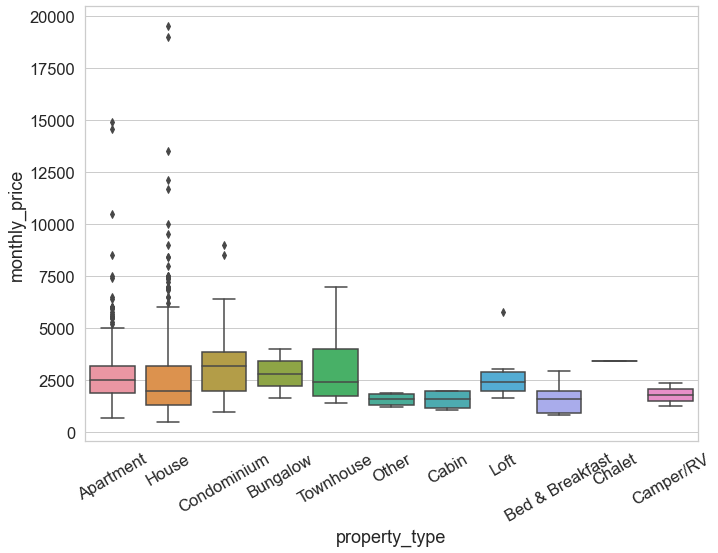

In [679]:
ax = sns.boxplot(x="property_type", y="monthly_price", data=df_abnb)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [680]:
#Below is all of the code for how I transformed the columns into numeric values.
df_abnb['property_type'] = df_abnb['property_type'].astype('category')
df_abnb.dtypes

zipcode                   object
property_type           category
room_type                 object
bathrooms                float64
bedrooms                 float64
monthly_price            float64
review_scores_rating     float64
dtype: object

In [681]:
df_abnb['property_type_cat'] = df_abnb['property_type'].cat.codes
df_abnb.head()

,zipcode,property_type,room_type,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat
1,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,96.0,0
9,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,97.0,0
11,98119,House,Entire home/apt,1.0,1.0,2000.0,97.0,7
12,98119,Apartment,Entire home/apt,1.0,2.0,5800.0,98.0,0
21,98119,House,Private room,1.5,1.0,2029.0,84.0,7


In [682]:
df_abnb['room_type'] = df_abnb['room_type'].astype('category')
df_abnb.dtypes

zipcode                   object
property_type           category
room_type               category
bathrooms                float64
bedrooms                 float64
monthly_price            float64
review_scores_rating     float64
property_type_cat           int8
dtype: object

In [683]:
df_abnb['room_type_cat'] = df_abnb['room_type'].cat.codes
df_abnb.head()

,zipcode,property_type,room_type,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
1,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,96.0,0,0
9,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,97.0,0,0
11,98119,House,Entire home/apt,1.0,1.0,2000.0,97.0,7,0
12,98119,Apartment,Entire home/apt,1.0,2.0,5800.0,98.0,0,0
21,98119,House,Private room,1.5,1.0,2029.0,84.0,7,1


In [684]:
df_abnb = df_abnb[['zipcode', 'bathrooms', 'bedrooms', 'monthly_price', 'review_scores_rating', 'property_type_cat', 'room_type_cat']]

In [685]:
df_abnb.head()

,zipcode,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
1,98119,1.0,1.0,3000.0,96.0,0,0
9,98119,1.0,1.0,3000.0,97.0,0,0
11,98119,1.0,1.0,2000.0,97.0,7,0
12,98119,1.0,2.0,5800.0,98.0,0,0
21,98119,1.5,1.0,2029.0,84.0,7,1


### Getting rid of outliers
When I initially tried to get rid of outliers using a z score it was much too agressive of a technique.  I ended up using an interquartile range technique which had its drawbacks as well.  I could only do one column so I chose monthly price because I felt like it had the most extreme outliers.

In [686]:
df_abnb.describe()

,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
count,1032.000000,1032.000000,1032.000000,1032.00000,1032.000000,1032.000000
mean,1.228198,1.298450,2708.527132,94.05814,3.795543,0.311047
std,0.549675,0.844953,1791.401138,7.32656,3.564272,0.524061
min,0.500000,0.000000,520.000000,20.00000,0.000000,0.000000
25%,1.000000,1.000000,1650.000000,92.00000,0.000000,0.000000
50%,1.000000,1.000000,2312.500000,96.00000,7.000000,0.000000
75%,1.000000,2.000000,3200.000000,99.00000,7.000000,1.000000
max,4.500000,6.000000,19500.000000,100.00000,10.000000,2.000000


In [687]:
min_threshold, max_threshold = df_abnb.monthly_price.quantile([0.25, 0.75])
min_threshold, max_threshold

(1650.0, 3200.0)

In [688]:
df_1 = df_abnb[(df_abnb.monthly_price < max_threshold) & (df_abnb.monthly_price > min_threshold)]

In [689]:
df_1.shape

(492, 7)

In [690]:
#The only other thing that looked like it might it cause problems was the review scores rating 
#column so I got rid of anyhing below the .25 quartile range.

In [691]:
df_1 = df_1[df_1['review_scores_rating'] > 92]

In [692]:
df_1.shape

(366, 7)

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'monthly_price'}>,
        <AxesSubplot:title={'center':'review_scores_rating'}>],
       [<AxesSubplot:title={'center':'property_type_cat'}>,
        <AxesSubplot:title={'center':'room_type_cat'}>]], dtype=object)

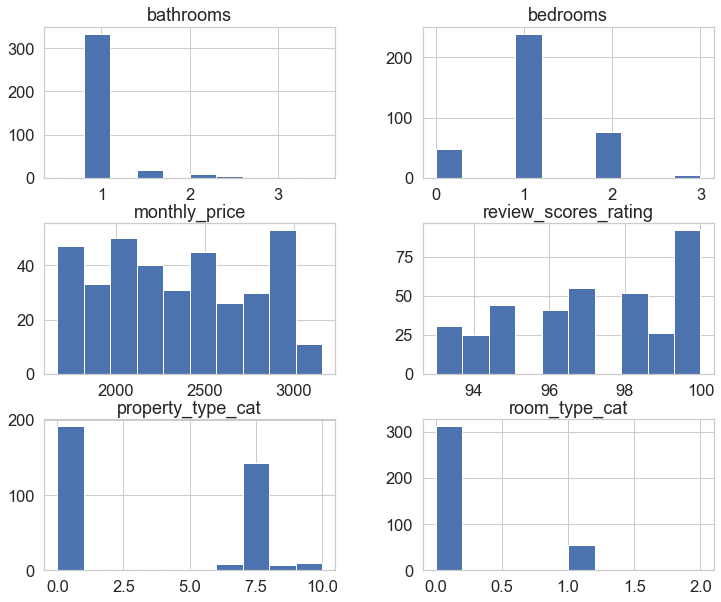

In [693]:
#looking at the distribution of each column.

df_1.hist(figsize = (12,10))

In [694]:
df_abnb['zipcode'] = df_abnb['zipcode'].astype('int')
df_abnb.dtypes

zipcode                   int64
bathrooms               float64
bedrooms                float64
monthly_price           float64
review_scores_rating    float64
property_type_cat          int8
room_type_cat              int8
dtype: object

In [695]:
#looking at the correlation between all of the columns.

df_abnb.corr()

,zipcode,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
zipcode,1.000000,0.091660,0.079374,-0.041459,0.050569,0.126911,0.020218
bathrooms,0.091660,1.000000,0.618600,0.520524,0.035599,0.245875,-0.127112
bedrooms,0.079374,0.618600,1.000000,0.584791,0.026180,0.256996,-0.209847
monthly_price,-0.041459,0.520524,0.584791,1.000000,0.074633,-0.032328,-0.431006
review_scores_rating,0.050569,0.035599,0.026180,0.074633,1.000000,0.073849,-0.023408
property_type_cat,0.126911,0.245875,0.256996,-0.032328,0.073849,1.000000,0.354985
room_type_cat,0.020218,-0.127112,-0.209847,-0.431006,-0.023408,0.354985,1.000000


<AxesSubplot:>

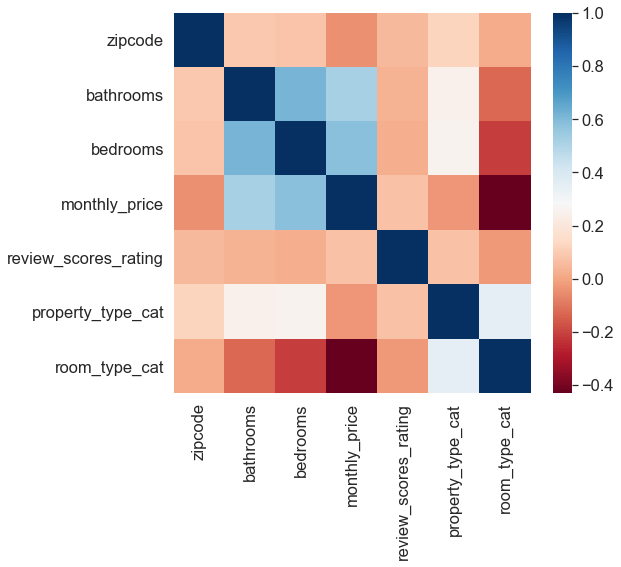

In [696]:
#Looking at the correlation between different columns to check for multicollinearity.

plt.figure(figsize = (8,7))
sns.heatmap(df_abnb.corr(), cmap = 'RdBu')

## KC Housing Data
First downloading the data.  We are looking at housng data from homes which come from the King County area in Seattle.  The scenario is for an investor looking to invest in homes in this area that will turn a profit.  The data comes from open source data from the king county website as well as information on airbnbs in this area from the Airbnb website.  Unfortunately when I tried to merge the two sets of data it caused the linear model for the KC housing data to become unfavorable with low R2 values and high p values.  However after analyzing the data from Airbnb we know that the homes with high review ratings and a monthly rate within the desired interquartile range will have between 0 and 6 bedrooms, .5 and 4 baths, and will be in the same zipcodes as out KC housng data. 

In [697]:
df = pd.read_csv('data/kc_house_data.csv')

In [698]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [699]:
#taking a look into data types.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [700]:
#looking at the data to see if anything stands out within the interquartile ranges as well as max, min, and mean.

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Cleaning the data.

In [701]:
# First dropping date.  I am not interested in the time of year this sells as it will be a rental unit. 
#Also dropping square foot basement.  It is another object that has no use for me.
df.drop('date', inplace = True, axis = 1)

In [702]:
df.drop('sqft_basement', inplace = True, axis = 1)

In [703]:
#checking to see it worked.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

In [704]:
#changing everything to a float so that I can use a z score multiplier on it later.

df.astype('float')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7.129301e+09,221900.0,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3.0,7.0,1180.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,6.414100e+09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,5.631500e+09,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,1933.0,NaN,98028.0,47.7379,-122.233,2720.0,8062.0
3,2.487201e+09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,1.954401e+09,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2.630000e+08,360000.0,3.0,2.50,1530.0,1131.0,3.0,0.0,0.0,3.0,8.0,1530.0,2009.0,0.0,98103.0,47.6993,-122.346,1530.0,1509.0
21593,6.600060e+09,400000.0,4.0,2.50,2310.0,5813.0,2.0,0.0,0.0,3.0,8.0,2310.0,2014.0,0.0,98146.0,47.5107,-122.362,1830.0,7200.0
21594,1.523300e+09,402101.0,2.0,0.75,1020.0,1350.0,2.0,0.0,0.0,3.0,7.0,1020.0,2009.0,0.0,98144.0,47.5944,-122.299,1020.0,2007.0
21595,2.913101e+08,400000.0,3.0,2.50,1600.0,2388.0,2.0,NaN,0.0,3.0,8.0,1600.0,2004.0,0.0,98027.0,47.5345,-122.069,1410.0,1287.0


In [705]:
#Dropping all NaN values.
df = df.dropna(axis = 0)

In [706]:
#check for nulls
display(df.isnull().any())
df.shape

id               False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

(15762, 19)

In [707]:
df.isnull().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [708]:
#looking to see that the shape is smaller from dropped values.
df.shape

(15762, 19)

In [709]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,3890,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,98003,47.3097,-122.327,2238,6819


### Exploring the data for further cleaning:
I am looking at histograms of all of the columns to see what looks like it is going to be categorical, continuous, and to see if any shapes are different from the normal distribution therefore requiring further attention.  Right away we can see that the price, bedrooms, bathrooms, condition, yr_renovated, ext., all have heavy skews implying that there are some outliers that would prevent us from having normally distributed data.


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>]],
      dtype=objec

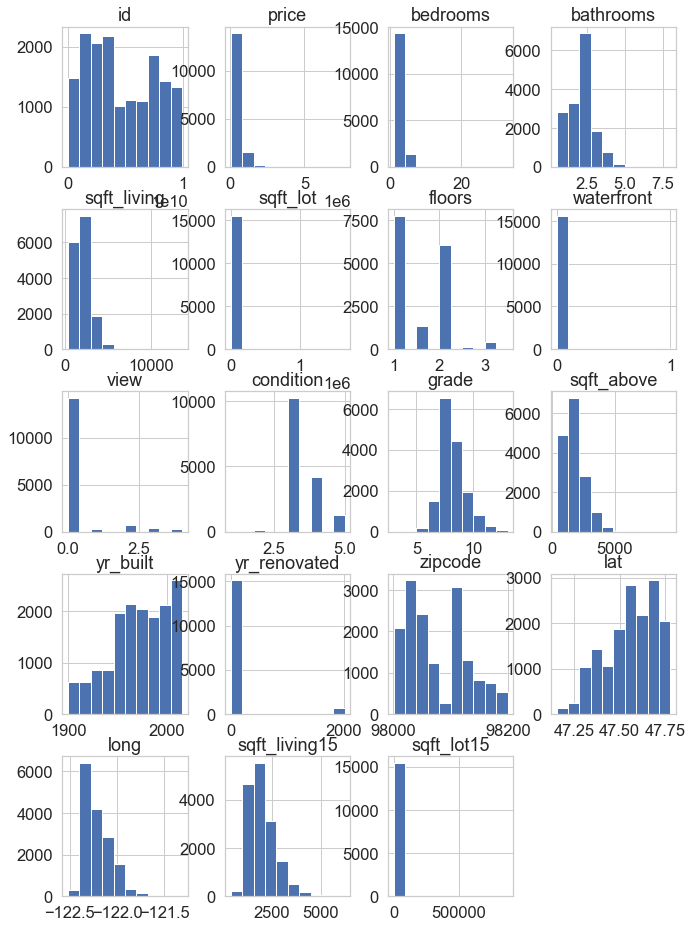

In [710]:
df.hist(figsize = (11,16))

#### Separating out by continuous and categorical data.
Below is code for separating out the columns to find out what is categorical and what is quatitative.  

In [711]:
conts= []
cats= []
for col in df.columns:
    if (df[col].nunique() < 25):
        cats.append(col)
    else: 
        conts.append(col)

In [712]:
df_conts = df.loc[:,conts]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>],
       [<AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

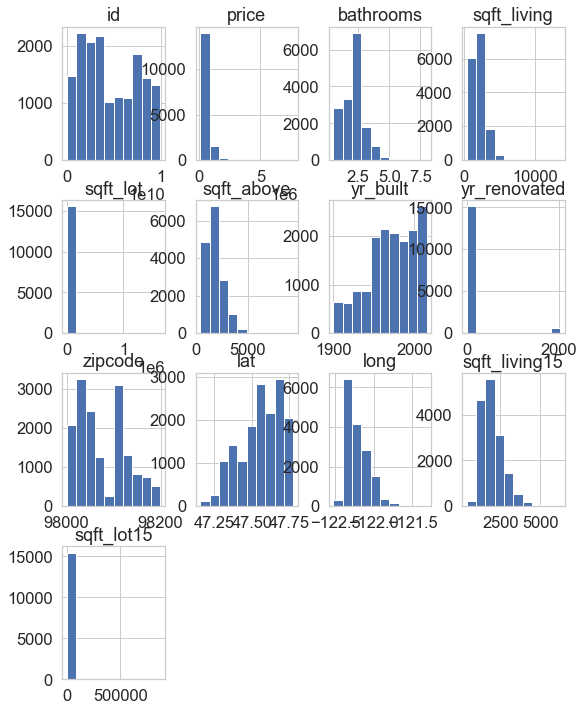

In [713]:
df_conts.hist(figsize = (9,12))

In [714]:
df_cats = df.loc[:,cats]

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>],
       [<AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>]], dtype=object)

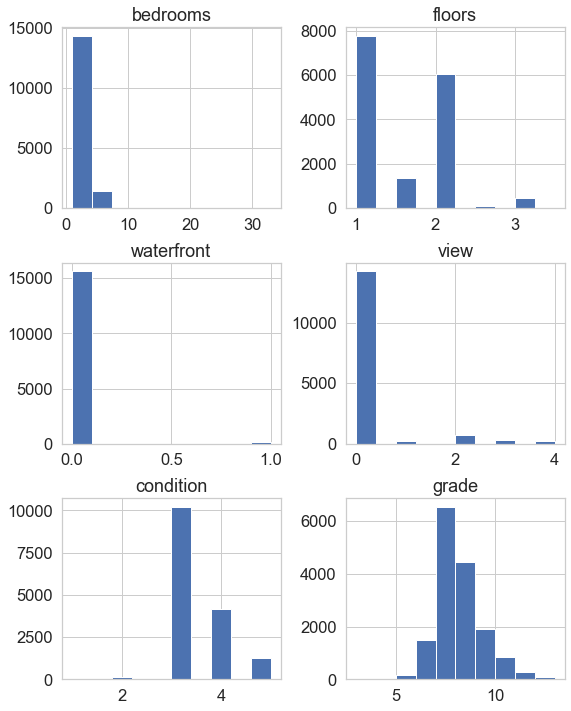

In [715]:
df_cats.hist(figsize = (9,12))

In [716]:
list(df_conts.columns)

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [717]:
list(df_cats.columns)

['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

### Removing outliers
I really wanted to use a z score because of the fact that it is more agressive and requires less time picking through individual columns.  This data set was large enough that I was able to use the z score method with a little additional cleaning.

#### yr_renovated
yr_renovated is an important column for this expoloratory analysis. However because most of the homes have not been renovated they are marked with 0 and therefore it is hard to make this appear as continuous data with out splitting up the data frame. It also becomes thrown off when put into a z score. This means for the final model I think I am going to end up dropping this column and exploring the data associated with this column in separate notebooks.

In [718]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

###  Correlation and Multicollinearity.

In [719]:
#Checking the correlation between columns.
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.002103,0.010158,0.029897,0.021317,-0.118189,0.032503,NaN,0.019919,-0.029400,0.033633,0.026770,0.038664,NaN,-0.019391,-0.013680,0.050120,0.022516,-0.110257
price,0.002103,1.000000,0.307282,0.445645,0.627371,0.099006,0.273268,NaN,0.195505,0.050880,0.636901,0.535921,0.063676,NaN,-0.040487,0.429493,0.076473,0.553979,0.091380
bedrooms,0.010158,0.307282,1.000000,0.491848,0.613787,0.114475,0.158953,NaN,0.048182,0.022281,0.341140,0.485935,0.176054,NaN,-0.172980,-0.039415,0.178512,0.412335,0.117993
bathrooms,0.029897,0.445645,0.491848,1.000000,0.709140,0.059099,0.514080,NaN,0.066472,-0.145309,0.619367,0.628483,0.582368,NaN,-0.226793,-0.001226,0.284427,0.539058,0.065158
sqft_living,0.021317,0.627371,0.613787,0.709140,1.000000,0.231026,0.348100,NaN,0.135294,-0.069404,0.714134,0.850045,0.365070,NaN,-0.223851,0.033990,0.312916,0.751380,0.235187
sqft_lot,-0.118189,0.099006,0.114475,0.059099,0.231026,1.000000,-0.105253,NaN,0.028517,0.046079,0.141615,0.205397,0.017849,NaN,-0.180536,-0.051435,0.271369,0.271223,0.817852
floors,0.032503,0.273268,0.158953,0.514080,0.348100,-0.105253,1.000000,NaN,-0.022001,-0.286539,0.466357,0.539260,0.531758,NaN,-0.066477,0.044664,0.156409,0.276374,-0.108478
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,0.019919,0.195505,0.048182,0.066472,0.135294,0.028517,-0.022001,NaN,1.000000,0.040376,0.113416,0.048599,-0.063688,NaN,0.078877,0.009735,-0.070015,0.151508,0.018097
condition,-0.029400,0.050880,0.022281,-0.145309,-0.069404,0.046079,-0.286539,NaN,0.040376,1.000000,-0.180546,-0.181787,-0.403117,NaN,-0.001660,-0.015314,-0.101743,-0.119648,0.057708


<AxesSubplot:>

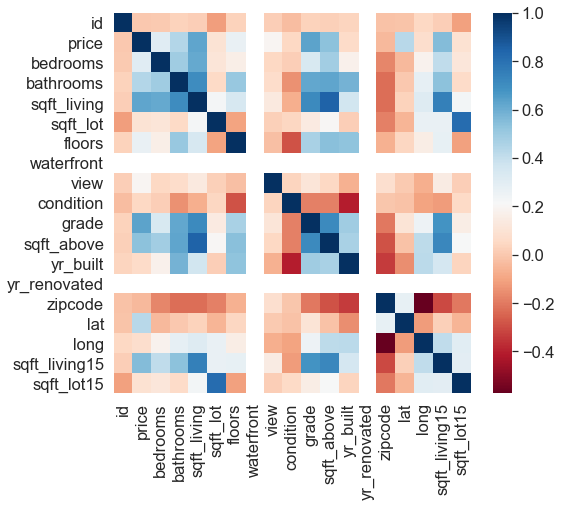

In [720]:
#Looking at the correlation between different columns to check for multicollinearity in a heat map.

plt.figure(figsize = (8,7))
sns.heatmap(df.corr(), cmap = 'RdBu')

In [721]:
bins = [0, 98003, 98005, 98010, 98030, 98040, 98050, 98060, 98080, 98199]
labels = ['Auburn', 'Bellvue', 'Black Diamond', 'Federal Way', 'Kirkland/Kent', 'Pacific', 'Renton', 'Sammammish', 'Seattle']
df['neighborhoods'] = pd.cut(df['zipcode'], bins, labels = labels)

df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,neighborhoods
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,Seattle
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammammish
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,98003,47.3097,-122.327,2238,6819,Auburn
8,2414600126,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,1960,0.0,98146,47.5123,-122.337,1780,8113,Seattle
9,3793500160,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,7,1890,2003,0.0,98038,47.3684,-122.031,2390,7570,Kirkland/Kent


In [722]:
bins = [0, 1, 3, 4, 6]
labels = ['Small', 'Medium', 'Large', 'Massive']
df['bedrooms'] = pd.cut(df['bedrooms'], bins, labels = labels)

df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,neighborhoods
3,2487200875,604000.0,Large,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,Seattle
4,1954400510,510000.0,Medium,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammammish
6,1321400060,257500.0,Medium,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,98003,47.3097,-122.327,2238,6819,Auburn
8,2414600126,229500.0,Medium,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,1960,0.0,98146,47.5123,-122.337,1780,8113,Seattle
9,3793500160,323000.0,Medium,2.50,1890,6560,2.0,0.0,0.0,3,7,1890,2003,0.0,98038,47.3684,-122.031,2390,7570,Kirkland/Kent


In [723]:
bins = [0, 1, 2.5, 3.5, 4.25]
labels = ['Small', 'Medium', 'Large', 'Massive']
df['bathrooms'] = pd.cut(df['bathrooms'], bins, labels = labels)

df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,neighborhoods
3,2487200875,604000.0,Large,Large,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,Seattle
4,1954400510,510000.0,Medium,Medium,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammammish
6,1321400060,257500.0,Medium,Medium,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,98003,47.3097,-122.327,2238,6819,Auburn
8,2414600126,229500.0,Medium,Small,1780,7470,1.0,0.0,0.0,3,7,1050,1960,0.0,98146,47.5123,-122.337,1780,8113,Seattle
9,3793500160,323000.0,Medium,Medium,1890,6560,2.0,0.0,0.0,3,7,1890,2003,0.0,98038,47.3684,-122.031,2390,7570,Kirkland/Kent


In [724]:
df = pd.get_dummies(df, columns = ['floors', 'waterfront', 'view', 'condition', 'grade', 'neighborhoods', 'bedrooms', 'bathrooms'], drop_first = True)


In [725]:
df

,id,price,sqft_living,sqft_lot,sqft_above,yr_built,yr_renovated,zipcode,lat,long,...,neighborhoods_Pacific,neighborhoods_Renton,neighborhoods_Sammammish,neighborhoods_Seattle,bedrooms_Medium,bedrooms_Large,bedrooms_Massive,bathrooms_Medium,bathrooms_Large,bathrooms_Massive
3,2487200875,604000.0,1960,5000,1050,1965,0.0,98136,47.5208,-122.393,...,0,0,0,1,0,1,0,0,1,0
4,1954400510,510000.0,1680,8080,1680,1987,0.0,98074,47.6168,-122.045,...,0,0,1,0,1,0,0,1,0,0
6,1321400060,257500.0,1715,6819,1715,1995,0.0,98003,47.3097,-122.327,...,0,0,0,0,1,0,0,1,0,0
8,2414600126,229500.0,1780,7470,1050,1960,0.0,98146,47.5123,-122.337,...,0,0,0,1,1,0,0,0,0,0
9,3793500160,323000.0,1890,6560,1890,2003,0.0,98038,47.3684,-122.031,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,1310,1294,1180,2008,0.0,98116,47.5773,-122.409,...,0,0,0,1,1,0,0,1,0,0
21592,263000018,360000.0,1530,1131,1530,2009,0.0,98103,47.6993,-122.346,...,0,0,0,1,1,0,0,1,0,0
21593,6600060120,400000.0,2310,5813,2310,2014,0.0,98146,47.5107,-122.362,...,0,0,0,1,0,1,0,1,0,0
21594,1523300141,402101.0,1020,1350,1020,2009,0.0,98144,47.5944,-122.299,...,0,0,0,1,1,0,0,0,0,0


In [784]:
#Variance Inflation Factor
#This is some code that I found that checks for the severity of multicollinearity within a regression model.
#A variance inflation factor higher than 5 will show signs of multicollinearity and need to be dropped.

X1 = sm.tools.add_constant(df)

series_before = pd.Series([variance_inflation_factor(X1.values, i ) for i in range(X1.shape[1])], index = X1.columns)

print('DATA BEFORE')
print('-'*100)
display(series_before)


#dropping columns i think will cause problems
df_1_after = df.drop(['id', 'sqft_living15', 'sqft_lot15', 'sqft_lot', 'sqft_above', "yr_renovated", 'condition_3', 'floors_2.0', 'grade_6', 'zipcode', 'neighborhoods_Seattle', 'bedrooms_Medium'], axis = 1)
X2 = sm.tools.add_constant(df_1_after)
series_after = pd.Series([variance_inflation_factor(X2.values, i ) for i in range(X2.shape[1])], index = X2.columns)

print('DATA AFTER')
print('-'*100)
display(series_after)

/Users/andrewozbun/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/andrewozbun/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


DATA BEFORE
----------------------------------------------------------------------------------------------------


const                           0.000000
id                              1.037597
price                           3.668303
sqft_living                     7.128350
sqft_lot                        3.095962
sqft_above                      6.707596
yr_built                        3.316974
yr_renovated                         NaN
zipcode                         8.907397
lat                             1.816798
long                            2.921064
sqft_living15                   3.173214
sqft_lot15                      3.198069
floors_1.5                      1.343721
floors_2.0                      2.660508
floors_2.5                      1.054212
floors_3.0                      1.479311
view_1.0                        1.044626
view_2.0                        1.087815
condition_3                    30.945270
condition_4                    26.683644
condition_5                    10.911483
grade_6                        10.125232
grade_7                        27.820673
grade_8         

DATA AFTER
----------------------------------------------------------------------------------------------------


const                          2.676719e+06
price                          3.478702e+00
sqft_living                    3.951258e+00
yr_built                       2.822218e+00
lat                            1.593262e+00
long                           2.770224e+00
floors_1.5                     1.254170e+00
floors_2.5                     1.016838e+00
floors_3.0                     1.216610e+00
view_1.0                       1.031233e+00
view_2.0                       1.062258e+00
condition_4                    1.272078e+00
condition_5                    1.238668e+00
grade_7                        3.692751e+00
grade_8                        4.741081e+00
grade_9                        3.942790e+00
grade_10                       2.626307e+00
grade_11                       1.393131e+00
neighborhoods_Bellvue          1.194822e+00
neighborhoods_Black Diamond    1.369140e+00
neighborhoods_Federal Way      1.734839e+00
neighborhoods_Kirkland/Kent    1.570962e+00
neighborhoods_Pacific          1

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>],
       [<AxesSubplot:title={'center':'floors_1.5'}>,
        <AxesSubplot:title={'center':'floors_2.5'}>,
        <AxesSubplot:title={'center':'floors_3.0'}>,
        <AxesSubplot:title={'center':'view_1.0'}>,
        <AxesSubplot:title={'center':'view_2.0'}>],
       [<AxesSubplot:title={'center':'condition_4'}>,
        <AxesSubplot:title={'center':'condition_5'}>,
        <AxesSubplot:title={'center':'grade_7'}>,
        <AxesSubplot:title={'center':'grade_8'}>,
        <AxesSubplot:title={'center':'grade_9'}>],
       [<AxesSubplot:title={'center':'grade_10'}>,
        <AxesSubplot:title={'center':'grade_11'}>,
        <AxesSubplot:title={'center':'neighborhoods_Bellvue'}>,
        <AxesSubplot:title={'center':'neighborhoods_Black Diamond'

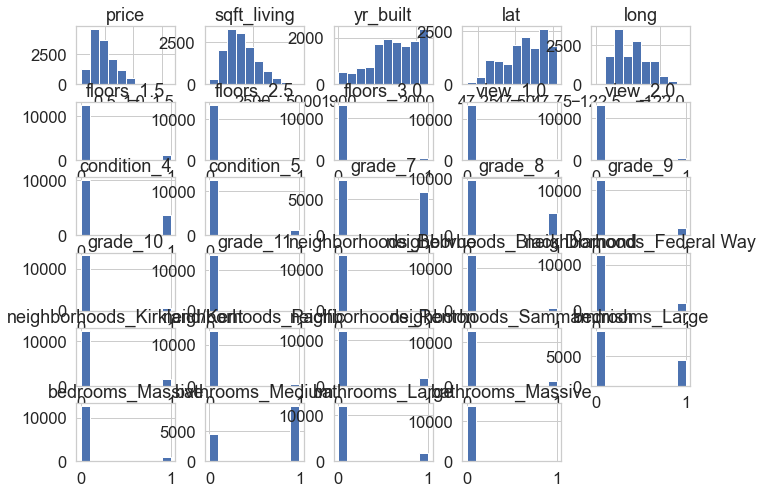

In [785]:
df_1_after.hist()

### Testing and training data.

In [786]:
# Setting out X and y equal to their respective columns.
X = df_1_after.drop('price', axis = 1)
y = df_1_after[['price']]

#Split dataset into training and testing portion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#create instance of our model
regression_model = LinearRegression()
#fit the model
regression_model.fit(X_train, y_train)

LinearRegression()

In [787]:
len(X_test)

2745

In [788]:
y_hat_train = regression_model.predict(X_train)
y_hat_test = regression_model.predict(X_test)

In [789]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

In [790]:
print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

Train MSE: 15501897379.688229
Test MSE: 16592296400.872969


In [791]:
print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

RMSE Train: 124506.61580690493
RMSE Test: 128811.08803543649


### Fitting the model and final exploration to look for abnormalities.

In [792]:
r2_score(y_test, y_hat_test)

0.7161418257161241

In [793]:
#Exploring the intercept and coefficient

intercept = regression_model.intercept_[0]
coef = regression_model.coef_[0][0]

print('The intercept for our model is {:.4}'.format(intercept))
print('-'*100)

#Loop through the dictionary and print the coeffcient data
#so, for instance, for each unit in bathroom, there is a .00028% rise in price.
for coef in zip(X.columns, regression_model.coef_[0]):
    print('The Coefficient for {} is {:.2}'.format(coef[0], coef[1]))

The intercept for our model is -1.855e+07
----------------------------------------------------------------------------------------------------
The Coefficient for sqft_living is 1.1e+02
The Coefficient for yr_built is -1.3e+03
The Coefficient for lat is 5.5e+05
The Coefficient for long is 4e+04
The Coefficient for floors_1.5 is 2.7e+04
The Coefficient for floors_2.5 is 1e+05
The Coefficient for floors_3.0 is 2.1e+04
The Coefficient for view_1.0 is 9.6e+04
The Coefficient for view_2.0 is 8.1e+04
The Coefficient for condition_4 is 1.9e+04
The Coefficient for condition_5 is 5.8e+04
The Coefficient for grade_7 is 5.6e+04
The Coefficient for grade_8 is 1.4e+05
The Coefficient for grade_9 is 2.8e+05
The Coefficient for grade_10 is 3.6e+05
The Coefficient for grade_11 is 4.9e+05
The Coefficient for neighborhoods_Bellvue is 2.5e+05
The Coefficient for neighborhoods_Black Diamond is 4.5e+04
The Coefficient for neighborhoods_Federal Way is -4.7e+04
The Coefficient for neighborhoods_Kirkland/Kent

In [794]:
X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1)
est = model.fit()

In [795]:
#Homoscedasticity checks using breusch pagan test
_, pval, _, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)

0.0 0.0


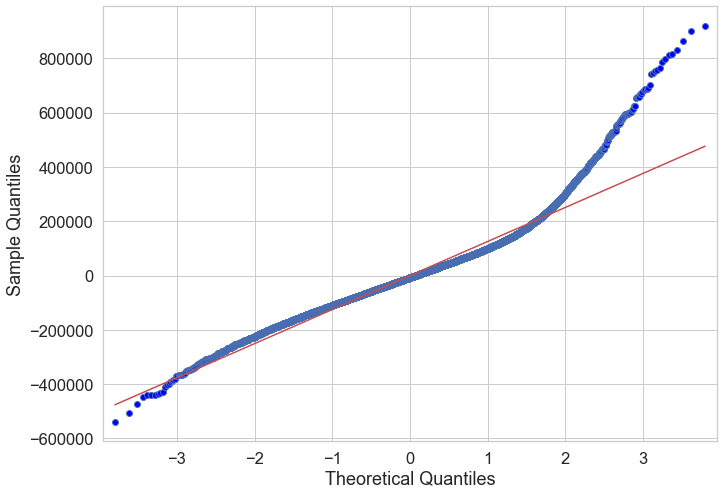

Mean: -1.3010646433726114e-08


In [796]:
#check for the normality of the residuals
sm.qqplot(est.resid, line = 's')
pylab.show()

#check that the mean of the residuals is approx. 0
mean_residuals = sum(est.resid) / len(est.resid)
print("Mean:", mean_residuals)

In [797]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1212.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:56:31   Log-Likelihood:            -1.8058e+05
No. Observations:               13724   AIC:                         3.612e+05
Df Residuals:                   13695   BIC:                         3.614e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             